In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from typing import Tuple
import scipy.stats as stats

In [2]:
# Create the normal data
X_normal, _ = make_blobs(n_samples=500, centers=1, n_features=2, cluster_std=1, random_state=42)[:2]
df_normal = pd.DataFrame({'feature1': X_normal[:, 0], 'feature2': X_normal[:, 1], 'anomaly_indicator': 0})

# Create the anomaly data
X_anomaly, _ = make_blobs(n_samples=20, centers=1, n_features=2, cluster_std = 3, random_state=42)[:2]
df_anomaly = pd.DataFrame({'feature1': X_anomaly[:, 0], 'feature2': X_anomaly[:, 1], 'anomaly_indicator': 1})

# Combine the normal and the anomaly data
df = pd.concat([df_normal, df_anomaly])
df.head()

,feature1,feature2,anomaly_indicator
0,0.569683,10.133861,0
1,-2.686145,8.215989,0
2,-2.981129,10.103237,0
3,-2.522695,7.956575,0
4,-1.922341,11.204742,0


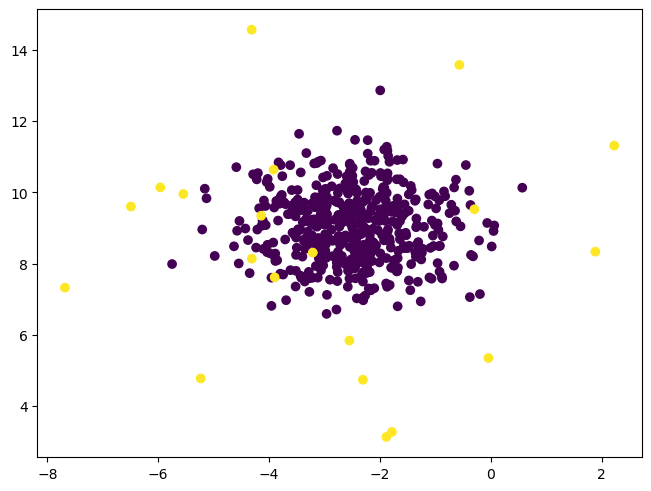

In [3]:
fig, ax = plt.subplots(layout='constrained')

ax.scatter(df['feature1'], df['feature2'], c=df['anomaly_indicator'])
plt.show()

In [4]:
def fit_params(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    return np.mean(X, axis=0), np.std(X, axis=0)

def compute_probs(X: np.ndarray, mu: np.ndarray, std: np.ndarray) -> np.ndarray:
    return np.prod(np.asarray([stats.norm.pdf(X[:, j], loc=mu[j], scale=std[j]) for j in range(X.shape[1])]), axis=0)

In [5]:
rng = np.random.default_rng(seed=0)

In [6]:
y = df.values[:, -1]
X = df.values[:, :-1]

X_normal = X[y == 0]
X_anomaly = X[y == 1]

X_train, X_val = train_test_split(X_normal, test_size=.1, random_state=0)
y_val = np.concatenate((np.zeros(X_val.shape[0], dtype=int), np.ones(X_anomaly.shape[0], dtype=int)))
X_val = np.concatenate((X_val, X_anomaly))

del X
del X_normal
del X_anomaly
del y

print(X_train.shape)
print(X_val.shape)
print(y_val.shape)

(450, 2)
(70, 2)
(70,)


In [7]:
mu, sigma = fit_params(X_train)
probs = compute_probs(X_train, mu, sigma)

print(probs.shape)

(450,)


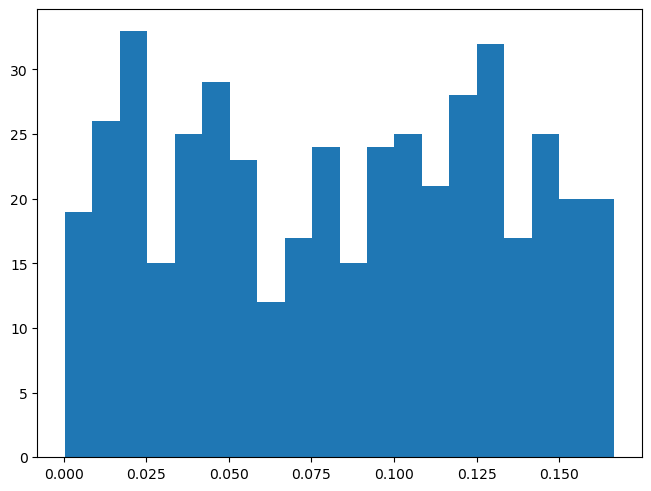

In [8]:
fig, ax = plt.subplots(layout='constrained')

ax.hist(probs, bins=20)

plt.show()

In [9]:
def precision(y_hat: np.ndarray, y_true: np.ndarray) -> np.floating:
    tp = np.sum(y_hat & y_true)
    denom = np.sum(y_hat)

    if np.isclose(denom, 0): return 0.0
    return tp / denom


def recall(y_hat: np.ndarray, y_true: np.ndarray) -> np.floating:
    tp = np.sum(y_hat & y_true)
    denom = np.sum(y_true)

    if np.isclose(denom, 0): return 0.0
    return tp / denom


def f1_score(y_hat: np.ndarray, y_true: np.ndarray) -> np.floating:
    p = precision(y_hat, y_true)
    r = recall(y_hat, y_true)

    if p + r == 0:
        return 0.0

    return (2 * p * r) / (p + r)

In [10]:
def find_epsilon(prob_val: np.ndarray, y_true: np.ndarray, n_eps: int=100) -> Tuple[float, float]:
    best_eps = 0.0
    best_f1 = 0.0
    for eps in np.linspace(prob_val.min(), prob_val.max(), num=n_eps):
        y_hat = (prob_val < eps).astype(int)
        f1 = f1_score(y_hat, y_true)

        if f1 > best_f1:
            best_f1 = f1
            best_eps = eps
    
    return best_eps, best_f1


In [11]:
probs_val = compute_probs(X_val, mu, sigma)
best_eps, best_f1 = find_epsilon(probs_val, y_val)


print(f'best eps: {best_eps}, best F1: {best_f1}')

best eps: 0.021368630078113585, best F1: 0.8372093023255814


In [17]:
y_pred = (probs_val < best_eps).astype(int)
X_anomaly_pred = X_val[y_pred == 1]

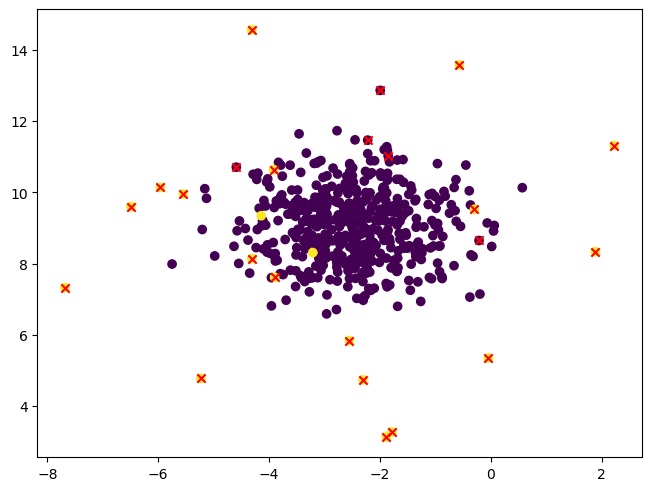

In [19]:
fig, ax = plt.subplots(layout='constrained')

ax.scatter(df.feature1, df.feature2, c=df.anomaly_indicator)
ax.scatter(X_anomaly_pred[:, 0], X_anomaly_pred[:, 1], marker='x', c='r')

plt.show()